In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from PIL import Image
from datetime import datetime
import os
import random
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
torch.manual_seed(42)

num_data_dir = "./numeric_data_longterm/"
text_data_dir = "./text_data/"
num_agre_dir =  "./num_aggregated_data/"

cuda


aggregate all the numeric data by date and save as one dataframe

In [6]:

spydata = pd.read_csv(num_data_dir + "spy.csv")
spydata = spydata[["Date","Open","High","Low","Close","Volume"]]
spydata["Date"] = pd.to_datetime(spydata["Date"])
spydata.rename(columns={'Open': 'Open_spy', 'Close': 'Close_spy','Volume':'Volume_spy'}, inplace=True)
# print("----------------------------------------------------------")
# print(spydata.head(2))
# spydata.info()
headdate = spydata.iloc[0]["Date"]

vixdata = pd.read_csv(num_data_dir + "vix.csv")
vixdata["Date"] = pd.to_datetime(vixdata["Date"])
vixdata = vixdata[vixdata["Date"] >= headdate]
vixdata = vixdata[["Date","Open","Close"]]
vixdata.rename(columns={'Open': 'Open_vix', 'Close': 'Close_vix'}, inplace=True)
# print("----------------------------------------------------------")
# print(vixdata.head(2))
# vixdata.info()

bonddata = pd.read_csv(num_data_dir + "tnx.csv")
bonddata = bonddata[["Date","Open","Close"]]
bonddata["Date"] = pd.to_datetime(bonddata["Date"])
bonddata = bonddata[bonddata["Date"] >= headdate]
bonddata.rename(columns={'Open': 'Open_tnx', 'Close': 'Close_tnx'}, inplace=True)
# print("----------------------------------------------------------")
# print(bonddata.head(2))
# bonddata.info()

eurousddata = pd.read_csv(num_data_dir + "usdindex.csv")
eurousddata = eurousddata[["Date","Open","Close"]]
eurousddata["Date"] = pd.to_datetime(eurousddata["Date"])
eurousddata = eurousddata[eurousddata["Date"] >= headdate]
eurousddata.rename(columns={'Open': 'Open_usd', 'Close': 'Close_usd'}, inplace=True)
# print("----------------------------------------------------------")
# print(eurousddata.head(2))
# eurousddata.info()

oildata = pd.read_csv(num_data_dir + "crudeoil.csv")
oildata = oildata[["Day","Price"]]
oildata["Day"] = pd.to_datetime(oildata["Day"])
oildata = oildata[oildata["Day"] >= headdate]
oildata.rename(columns={'Day': 'Date','Price': 'Price_oil'}, inplace=True)
# print("----------------------------------------------------------")
# print(oildata.head(2))
# oildata.info()

golddata = pd.read_csv(num_data_dir + "gold.csv")
golddata = golddata[["Date","Price"]]
golddata["Date"] = pd.to_datetime(golddata["Date"])
golddata = golddata[golddata["Date"] >= headdate]
golddata.rename(columns={'Price': 'Price_gold'}, inplace=True)
golddata['Price_gold'] = golddata['Price_gold'].str.replace(",", "")
golddata['Price_gold'] = pd.to_numeric(golddata['Price_gold'], errors="coerce")
# print("----------------------------------------------------------")
# print(golddata.head(2))
# golddata.info()

nikkeidata = pd.read_csv(num_data_dir + "nikkei.csv")
nikkeidata = nikkeidata[["Date","Open","Close"]]
nikkeidata["Date"] = pd.to_datetime(nikkeidata["Date"])
nikkeidata = nikkeidata[nikkeidata["Date"] >= headdate]
nikkeidata.rename(columns={'Open': 'Open_nikkei', 'Close': 'Close_nikkei'}, inplace=True)
# print("----------------------------------------------------------")
# print(nikkeidata.head(2))
# nikkeidata.info()

yieldcurvedata = pd.read_csv(num_data_dir + "yieldcurve.csv")
yieldcurvedata["DATE"] = pd.to_datetime(yieldcurvedata["DATE"])
yieldcurvedata = yieldcurvedata[yieldcurvedata["DATE"] >= headdate]
yieldcurvedata.rename(columns={'DATE': 'Date', 'DGS10': 'Rate_yieldcurve'}, inplace=True)
yieldcurvedata['Rate_yieldcurve'] = pd.to_numeric(yieldcurvedata['Rate_yieldcurve'], errors="coerce")
# print("----------------------------------------------------------")
# print(yieldcurvedata.head(2))
# yieldcurvedata.info()

In [7]:
#join the above data into one dataframe
combined = pd.merge(spydata, vixdata, left_on='Date',right_on='Date',how='left')
combined = pd.merge(combined, bonddata, left_on='Date',right_on='Date',how='left')
combined = pd.merge(combined, eurousddata, left_on='Date',right_on='Date',how='left')
combined = pd.merge(combined, yieldcurvedata, left_on='Date',right_on='Date',how='left')
combined = pd.merge(combined, oildata, left_on='Date',right_on='Date',how='left')
combined = pd.merge(combined, golddata, left_on='Date',right_on='Date',how='left')
combined = pd.merge(combined, nikkeidata, left_on='Date',right_on='Date',how='left')


print(combined.head(5))
combined.info()

        Date  Open_spy      High       Low  Close_spy  Volume_spy  Open_vix  \
0 1993-01-29  43.96875  43.96875  43.75000   43.93750     1003200     12.49   
1 1993-02-01  43.96875  44.25000  43.96875   44.25000      480500     12.51   
2 1993-02-02  44.21875  44.37500  44.12500   44.34375      201300     12.47   
3 1993-02-03  44.40625  44.84375  44.37500   44.81250      529400     11.98   
4 1993-02-04  44.96875  45.09375  44.46875   45.00000      531500     11.86   

   Close_vix  Open_tnx  Close_tnx   Open_usd  Close_usd  Rate_yieldcurve  \
0      12.42      6.39       6.39  91.440002  92.459999             6.39   
1      12.33      6.38       6.38  92.470001  93.559998             6.38   
2      12.25      6.46       6.46  93.599998  93.919998             6.46   
3      12.12      6.45       6.45  93.910004  94.239998             6.45   
4      12.29      6.39       6.39  94.180000  94.529999             6.39   

   Price_oil  Price_gold   Open_nikkei  Close_nikkei  
0      20.27 

In [8]:
# modify fedrate data date format
fedratedata = pd.read_csv(num_data_dir + "FEDFUNDS.csv")
# print("----------------------------------------------------------")
fedratedata["DATE"] = pd.to_datetime(fedratedata["DATE"])
fedratedata.rename(columns={'DATE':'Date', 'FEDFUNDS': 'Rate_fed'}, inplace=True)
fedratedata.set_index('Date',inplace=True)
fedratedata = fedratedata.reindex(pd.date_range(start=fedratedata.index.min(), end=fedratedata.index.max(),freq='1D'))
fedratedata = fedratedata.interpolate(method='linear')
fedratedata["Date"] = fedratedata.index
# print(fedratedata.head(2))
# fedratedata.info()

# add the monthly and weekly data, will be interpolated to day
cpidata = pd.read_csv(num_data_dir + "cpi.csv")
cpidata.rename(columns={'DATE': 'Date', 'CPIAUCSL': 'Cpi'}, inplace=True)
cpidata["Date"] = pd.to_datetime(cpidata["Date"])
cpidata.set_index('Date',inplace=True)
cpidata_reidx = cpidata.reindex(pd.date_range(start=cpidata.index.min(), end=cpidata.index.max(),freq='1D'))
cpidata_reidx = cpidata_reidx.interpolate(method='linear')
cpidata_reidx["Date"] = cpidata_reidx.index
# print("----------------------------------------------------------")
# print(cpidata_reidx.head(2))
# cpidata_reidx.info()

joblessdata = pd.read_csv(num_data_dir + "initclaims.csv")
joblessdata.rename(columns={'DATE': 'Date', 'ICNSA': 'Jobless_claims'}, inplace=True)
joblessdata["Date"] = pd.to_datetime(joblessdata["Date"])
joblessdata.set_index('Date',inplace=True)
joblessdata_reidx = joblessdata.reindex(pd.date_range(start=joblessdata.index.min(), end=joblessdata.index.max(),freq='1D'))
joblessdata_reidx = joblessdata_reidx.interpolate(method='linear')
joblessdata_reidx["Date"] = joblessdata_reidx.index
# print("----------------------------------------------------------")
# print(joblessdata_reidx.head(2))
# joblessdata_reidx.info()

# # add to combined
combined = pd.merge(combined, fedratedata, on="Date",how='left')
combined = pd.merge(combined, cpidata_reidx, on="Date",how='left')
combined = pd.merge(combined, joblessdata_reidx, on='Date',how='left')
# impute
combined = combined.ffill()  # Forward fill
combined.bfill(inplace=True) # reverse fill

print(combined.head(10))
combined.info()

        Date  Open_spy      High       Low  Close_spy  Volume_spy  Open_vix  \
0 1993-01-29  43.96875  43.96875  43.75000   43.93750     1003200     12.49   
1 1993-02-01  43.96875  44.25000  43.96875   44.25000      480500     12.51   
2 1993-02-02  44.21875  44.37500  44.12500   44.34375      201300     12.47   
3 1993-02-03  44.40625  44.84375  44.37500   44.81250      529400     11.98   
4 1993-02-04  44.96875  45.09375  44.46875   45.00000      531500     11.86   
5 1993-02-05  44.96875  45.06250  44.71875   44.96875      492100     12.56   
6 1993-02-08  44.96875  45.12500  44.90625   44.96875      596100     13.15   
7 1993-02-09  44.81250  44.81250  44.56250   44.65625      122100     13.63   
8 1993-02-10  44.65625  44.75000  44.53125   44.71875      379600     13.58   
9 1993-02-11  44.78125  45.12500  44.78125   44.93750       19500     13.05   

   Close_vix  Open_tnx  Close_tnx   Open_usd  Close_usd  Rate_yieldcurve  \
0      12.42      6.39       6.39  91.440002  92.45999

plot it for sanity and save

(7814, 20)


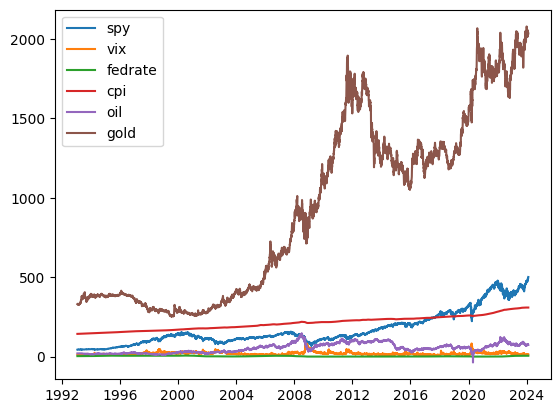

In [18]:
train = combined.iloc[:]
print(train.shape)
# train.info()
# train.to_pickle("num_aggregated_data/train2")
# test = combined.iloc[7108:]
# # test.info()
# test.to_pickle("num_aggregated_data/test2")

train = pd.read_pickle("num_aggregated_data/train2")
# plt.plot(train["Date"], train[:])
# plt.plot(train["Date"], train[["Close_spy", "Close_vix","Rate_fed","Cpi","Price_oil", "Price_gold"]])
plt.legend(("spy", "vix", "fedrate", "cpi", "oil", "gold"))
plt.show()